In [3]:
# I start with importing the packages needed for data manipulation
import numpy as np
import pandas as pd 

In [4]:
# Data visualisation package:

import matplotlib.pyplot as plt

In [5]:
# To prevent Jupyter from limiting the columns that are shown:

pd.set_option('display.max_columns', None)

In [6]:
# Data modeling packages:

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

In [7]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [8]:
# Display feature importance:

from xgboost import plot_importance

In [9]:
df0 = pd.read_csv('waze_dataset.csv')

In [10]:
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [11]:
df = df0.copy()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


In [13]:
# Here comes my favourite part in building a predictive machine learning model: Feature Engineering
# I know from the available data the total distance driven, but knowing how many km is driven on average per driving day could also be helpful as a feature, so
# I will create a new column and add it to my df.  

df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

df['km_per_driving_day'].describe()



/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

In [14]:
# There are values of infinity. And I assume that this is because division by zero is undefined and some driving days could be zero. Let's check this out.

zero_driving_days = df[df['driving_days'] == 0]

print(zero_driving_days) 

          ID     label  sessions  drives  total_sessions  \
13        13  retained        80      64      132.830506   
14        14   churned        72      66      401.351809   
56        56   churned       150     127      187.708346   
64        64  retained         4       3      113.818787   
81        81   churned        26      23       83.166886   
...      ...       ...       ...     ...             ...   
14881  14881  retained       174     151      181.187455   
14957  14957  retained        24      24       42.953281   
14985  14985   churned        53      43      118.385655   
14988  14988   churned        13      11       41.804981   
14990  14990   churned        73      61      329.904300   

       n_days_after_onboarding  total_navigations_fav1  \
13                        3154                      39   
14                        2524                      54   
56                        2028                     208   
64                        1830                 

In [15]:
zero_driving_days = df[df['driving_days'] == 0].count()

print(zero_driving_days)

ID                         1024
label                       983
sessions                   1024
drives                     1024
total_sessions             1024
n_days_after_onboarding    1024
total_navigations_fav1     1024
total_navigations_fav2     1024
driven_km_drives           1024
duration_minutes_drives    1024
activity_days              1024
driving_days               1024
device                     1024
km_per_driving_day         1024
dtype: int64


In [16]:
#As we have now confirmed that the infinite values are imputed by the library because of division by zero, I could argue that if there is no driving day in 
#1024 rows, their km_per_driving_day values should be zero. So we impute zeros to replace the values of infinity.

df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0


In [17]:
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

In [18]:
# This imputation allowed us to see the right descriptive statistics. Mean and max were previously 'inf'. 
# I will now create another feature that could potentially be useful.
# Basically I want a new column to represent the percentage of last month's sessions divided by total sessions.
# This could be a feature that our random forest classification algorithm can learn from.


In [19]:
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

In [20]:
# To briefly interpret the stats above, customers whose percentage of number of sessions in last month vs their total number of sessions is up to 69%
# make up 75% of the data. The 50% value (42%) is the median and it indicates that half of the data has values less than or equal to 42%. Looking at 
# the first quartile (25%), we see that a quarter of the data has values less than or equal to 19%. 
# This new feature I created could give an idea about recency of customers' usage of the services. But we will know how useful it is as a feature for the classification model
# only when we plot the importance of features. 

In [21]:
# A binary feature regarding whether a driver is professional or not could potentially be a predictor that the algorithm can learn from.
# Similar to the above, we will see if this holds to be true, after running the model. 
df['professional_driver'] = np.where((df['drives'] >=60) & (df['driving_days'] >=15), 1, 0)


In [22]:
df['professional_driver'].head(5)

0    1
1    0
2    0
3    0
4    1
Name: professional_driver, dtype: int64

In [23]:
# Total sessions per day can also be used as a feature. However, we do not have that data. With the existing data, though, it is possible to create a column
# that represents sessions per day. 

df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

In [24]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713


In [26]:
#mean kilometeres per hour driven can also be created as a column:

df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

In [27]:
# Max value shows an unrealistic speed. Clarification could be sought from the company about how this occured. 

In [28]:
# mean km per drive is another column that I will create using the available data.

df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

In [29]:
# There are infinite values observed, which is possibly because of zeros in the drives column. So the values of infinity are imputed with zeros: 

df.loc[df['km_per_drive'] == np.inf, ['km_per_drive']] = 0

df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

In [30]:
# The max value here is also unrealistic, which could be checked with the company regarding its reasons and see if extreme outliers like that are grounded.

In [31]:
df.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,1,0.130381,79.430298,11.632058
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0,0.266854,260.389902,128.186173
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0,0.051121,113.953460,32.201567
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,0,4.505948,93.351141,22.839778
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,1,0.107713,194.342970,58.091206


In [32]:
# The column for favorite places of users can also be explanatory in terms of customer churn. Individuals whose trips to locations not marked as favorites 
# constitute a larger proportion of their overall trips may have a reduced likelihood of churning. This is because they engage in more journeys to less familiar 
# destinations.

df['ratio_of_favourites_to_total_sessions'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

df['ratio_of_favourites_to_total_sessions'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: ratio_of_favourites_to_total_sessions, dtype: float64

In [33]:
# 25% of the data is below or equal to 0.20, followed by 0.65 (50%) and 1.64(75%). 
# Since total drives since onboarding are not known, this is a proxy representation created using total sessions column in absence of total number of drives.

In [34]:
# Checking outliers (Tree-based models are resilient to outliers so no imputation is needed.)

columns_to_check = ['sessions', 'drives', 'total_sessions', 'n_days_after_onboarding', 'driven_km_drives']

# Definition of the function to identify outliers by calculating IQR
def count_outliers(column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    return outliers.shape[0] 

# Dictionary needed for the storage of the count of outliers
outlier_counts = {}

# For loop for iteration over columns and outliers. 
for column in columns_to_check:
    count = count_outliers(column)
    outlier_counts[column] = count

# To display the count of outliers for each column:
for column, count in outlier_counts.items():
    print(f"Number of outliers for {column}: {count}")


Number of outliers for sessions: 729
Number of outliers for drives: 734
Number of outliers for total_sessions: 515
Number of outliers for n_days_after_onboarding: 0
Number of outliers for driven_km_drives: 463


In [35]:
df.tail()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,professional_driver,total_sessions_per_day,km_per_hour,km_per_drive,ratio_of_favourites_to_total_sessions
14994,14994,retained,60,55,207.875622,140,317,0,2890.496901,2186.155708,25,17,iPhone,170.029229,0.288634,0,1.484826,79.330952,52.554489,1.524950
14995,14995,retained,42,35,187.670313,2505,15,10,4062.575194,1208.583193,25,20,Android,203.128760,0.223797,0,0.074918,201.686167,116.073577,0.133212
14996,14996,retained,273,219,422.017241,1873,17,0,3097.825028,1031.278706,18,17,iPhone,182.225002,0.646893,1,0.225316,180.232076,14.145320,0.040283
14997,14997,churned,149,120,180.524184,3150,45,0,4051.758549,254.187763,6,6,iPhone,675.293092,0.825374,0,0.057309,956.401322,33.764655,0.249274
14998,14998,retained,73,58,353.419797,3383,13,51,6030.498773,3042.436423,14,13,iPhone,463.884521,0.206553,0,0.104469,118.927687,103.974117,0.181088


In [36]:
# To be able to use device as a feature, it needs to be binary, as it is categorical at the moment. This will allow the classification model to make use of
# this data as well. 

df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].head()


,device,device2
0,Android,0
1,iPhone,1
2,Android,0
3,iPhone,1
4,Android,0


In [37]:
# As per the needs of the models, target variable (label column) should also be converted to binary: 0 for retained customers, 1 for churned customers. 

df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()


,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


In [38]:
'''As part of feature selection, no variables will be discarded as tree-based models can handle 
multicollinearity. Only the ID will be dropped as it does not include any information relevant
to modeling. '''

df = df.drop(['ID'], axis=1)

In [39]:
# Class balance is important to consider before modeling: 

df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

In [41]:
# Nearly 18% of the users churned, making this an unbalanced dataset. However, it is not at extremes. So, we do not need class rebalancing. 

'''I need to decide on which evaluation metric will be best for the purposes of my model. Accuracy will probably be an inefficient metric to look at. 
As accuracy is basically the number of correct predictions divided by the total number of predictions, it might fail to predict the minority class but
still have high accuracy on an imbalanced dataset.

What we know from the nature of this project is that falsely predicting that a customer will churn is not a big problem. They could just be receiving
emails or notifications through the app about retention campaigns even if unnecessarily, and that is pretty much about it. Noone will get hurt, lose resources,
or suffer any significant consequence when they are predicted to churn. 

As false positives are not an issue, we will select the model based on the recall score.'''

'I need to decide on which evaluation metric will be best for the purposes of my model. Accuracy will probably be an inefficient metric to look at. \nAs accuracy is basically the number of correct predictions divided by the total number of predictions, it might fail to predict the minority class but\nstill have high accuracy on an imbalanced dataset.\n\nWhat we know from the nature of this project is that falsely predicting that a customer will churn is not a big problem. They could just be receiving\nemails or notifications through the app about retention campaigns even if unnecessarily, and that is pretty much about it. Noone will get hurt, lose resources,\nor suffer any significant consequence when they are predicted to churn. \n\nAs false positives are not an issue, we will select the model based on the recall score.'

In [ ]:
''' The final modeling dataset has 14,999 samples. We now need to split the data into train/validation/test sets as 60 / 20 / 20%.
While deciding on the split ratio and if validation set to select a champion model will be used, I need to look at the numbers after splitting:
~3,000 samples will be in each validation and test sets, in which ~18% (540 samples) will represent churning user (minority class).

I will then fit models and tune hyperparameters on the training set and choose the champion model based on its performance on the validation set.

Finally the champion model's performance will be assessed on the test set. 

'''

In [42]:
# Data splitting into three as explained above.

X = df.drop(columns=['label', 'label2', 'device']) 

# Features are X. Label is now coded as binary (label2) so it is excluded. 
# label2  will be our target variable so it is reserved for y. 
# Finally, device was previously binary encoded so device2 is doing the job, so we drop the device column from the dataframe. 

y = df['label2'] 

X_tr, X_test, y_tr, y_test = train_test_split(X,y, stratify=y,
                                              test_size=0.2, random_state=40)

X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=40) 

In [43]:
#Number of samples in the partitioned data verified as follows: 
for x in [X_train, X_val, X_test]:
    print(len(x))

8999
3000
3000


In [44]:
''' 
First, we are going to begin with GridSearchCV to tune a random forest model. 

1) We will instantiate the random forest classifier (rf) and set the random state as above as the first step.

2) We then need to create a dictionary cv_params for hyperparameters and their corresponding values to tune. More tuning means a model better fit the data, but
the process will take longer. 

For a random forest classifier model the following are the hyperparameters  

max_depth (This parameter sets the maximum depth of each tree in the forest. It is important to note that a deeper tree may capture more complex patterns
in the data but can also lead to overfitting)

max_features (This parameter sets the maximum number of features considered for splitting a node. However, it is worth noting that the actual number of features
used in a split is a random subset of features, and 'max_features' controls the size of this subset. 

max_samples (In a random forest, each tree is trained on a random subset of the data with replacement, and 'max_samples' is implicitly determined by the size
of this random subset)

min_samples_leaf (This parameter sets the minimum number of samples that a leaf must have before it could divide. This parameter helps control the size of the
tree and can prevent overfitting.)

min_samples_split (This parameter sets the minimum number of samples that a child leaf must have if the leaf (internal node) splits. Similar to the min_samples_
leaf, this parameter helps control the size of the tree and can prevent overfitting.)

n_estimators (This parameter defines how many trees will be built. Whilst more trees can lead to a more robust and stable model, computation time will increase
with increased number of trees.)

3) The next bit should be defining scoring of scoring metrics for GridSearch to capture (precision,recall, F1 score, and accuracy)

4) Instantiate the GridSearchCV object rf_cv. Pass to it as arguments:

estimator = rf
param_grid = cv_params
scoring = scoring
cv: define the number of cross-validation folds we want (cv=_)
refit: set the evaluation metric we want to use to choose the model (refit=_)

refit should be set to recall as discussed and explained above. 
'''

rf = RandomForestClassifier(random_state=40)


cv_params = {'max_depth': [None, 10],               
             'max_features': ['auto', 0.5],                  
             'min_samples_leaf': [1, 4],                        
             'n_estimators': [100, 200],            
             }

scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')


In [45]:
%%time
rf_cv.fit(X_train, y_train) 

/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
32 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/

CPU times: user 4min 22s, sys: 3.11 s, total: 4min 26s
Wall time: 4min 41s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=40),
             param_grid={'max_depth': [None, 10], 'max_features': ['auto', 0.5],
                         'min_samples_leaf': [1, 4],
                         'n_estimators': [100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [46]:
# Best average score across all validation folds. 
rf_cv.best_score_

0.12024623566790994

In [47]:
# Best combination of hyperparameters:
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 100}

In [48]:
def make_results(model_name:str, model_object, metric:str):
    # Formulate a dictionary that associates the input metric with its corresponding metric name in GridSearchCV:
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Retrieve all outcomes from the cross-validation and store them in a DataFrame:
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Identify the row in the DataFrame with the highest score for the specified metric.
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Retrieve the accuracy, precision, recall, and F1 score values from that particular row.
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Generate a table displaying the results.
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

In [49]:
# To pass the GridSearch object to the make_results() function:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.4857,0.120246,0.192621,0.829648


In [50]:
xgb = XGBClassifier(objective='binary:logistic', random_state=40)

cv_params = {'max_depth': [3, 6, 9],
             'min_child_weight': [1, 5, 10],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [100, 200]
             }

scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'f1': 'f1'}

xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')


In [51]:
#We will now fit the model to the data:
xgb_cv.fit(X_train, y_train)

/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/muzaffer.ozhan/Documents/GitHub/Customer_Churn_Prediction/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=40, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 6, 9],
                         'min_child_weight': [1, 5, 10],
                         'n_estimators': [100, 200]},
             refit='recall',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [52]:
# Best average score across all validation folds:
xgb_cv.best_score_

0.14982732421605194

In [53]:
# Best combination of parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 200}

In [54]:
# I will now use the make_results()on the GridSearch object

xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.48570,0.120246,0.192621,0.829648
0,XGB cv,0.43006,0.149827,0.221924,0.822870


In [ ]:
'''This model exhibits a superior fit to the data compared to the random forest model. Moreover, it outperforms the random forest model in terms of recall while 
maintaining comparable accuracy, precision and F1 scores.'''

In [55]:
#Moving on to model selection, I now need to use the best rf model and the best XGBoost model to predict on the validation data. The one performing better will be the
#champion model. 

rf_val_preds = rf_cv.best_estimator_.predict(X_val)

In [56]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

Input:
    - model_name (string): The chosen name for the model in the output table.
    - preds: NumPy array containing test predictions.
    - y_test_data: NumPy array containing y_test data.

Output:
    - table: A Pandas DataFrame presenting precision, recall, F1, and accuracy scores for your model.

    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [57]:
# We now get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# and append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.485700,0.120246,0.192621,0.829648
0,XGB cv,0.430060,0.149827,0.221924,0.822870
0,RF val,0.421053,0.094675,0.154589,0.825000


In [ ]:
# All metrics decreased. This means that the model did not overfit the training data.

In [58]:
# XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Obtain validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Add the validation scores to the results table.
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.485700,0.120246,0.192621,0.829648
0,XGB cv,0.430060,0.149827,0.221924,0.822870
0,RF val,0.421053,0.094675,0.154589,0.825000
0,XGB val,0.379310,0.130178,0.193833,0.817000


In [ ]:
#Given XGBoost model's validation scores, it is still the champion model. 

In [59]:
# XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Obtain test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Add the test scores to the results table.
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.485700,0.120246,0.192621,0.829648
0,XGB cv,0.430060,0.149827,0.221924,0.822870
0,RF val,0.421053,0.094675,0.154589,0.825000
0,XGB val,0.379310,0.130178,0.193833,0.817000
0,XGB test,0.369942,0.126233,0.188235,0.816000


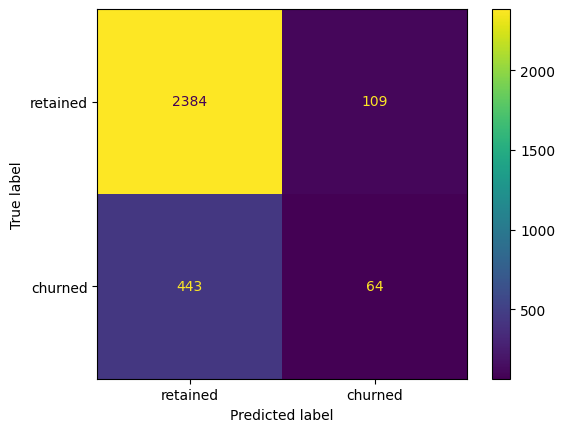

In [60]:
# To generate array of values for confusion matrix:
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# and plot confusion matrix:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

In [72]:
# The model successfully detected only 12.6% (recall) of users who indeed churned.

64 / (443+64)

0.126232741617357

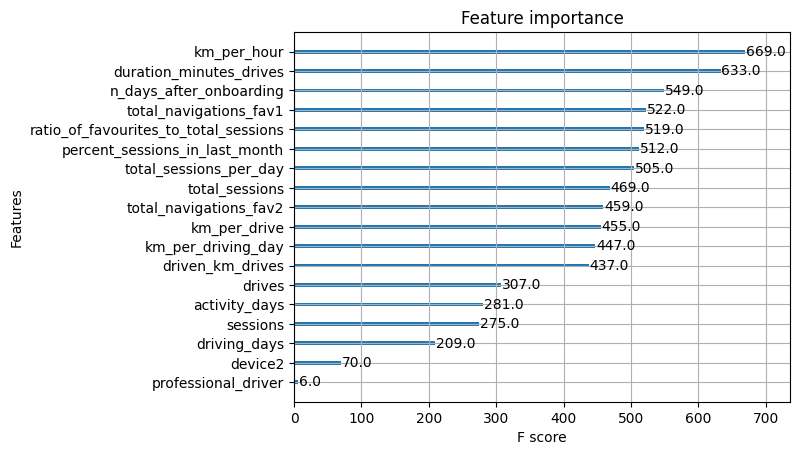

In [61]:
#To inspect the most important features of the model:

plot_importance(xgb_cv.best_estimator_);

In [ ]:
# The XGBoost model made use of various features to predict the target variable. This and the feature engineering together are of great importance. As seen from the
# feature importance plot above, the engineered features are among top 10 features. 

'''
To conclude if this model will be used for consequential business decisions, I would not recommend using the model for churn prediction. As it is clear from the low recall
score, the model does not have a high predictive power. In another notebook, I got only marginally better results in terms of recall score and those models took long to train.

The model can still be used to guide further exploratory efforts, in which case it could be valuable.

4 features that are engineered earlier are among the 10 most predictive features. Reconstructing the model with varying combinations of predictor variables could also
help reduce noise.

For enhanced model performance, incorporating drive-level details for each user, such as drive times and geographic locations, would be valuable. Obtaining more granular data
on user interactions with the app, such as the frequency of reporting or confirming road hazard alerts, could also provide valuable insights. Furthermore, having information 
on the monthly count of unique starting and ending locations entered by each driver would be beneficial.
'''

In [ ]:
'''By identifying an optimal decision threshold, our model can still be tailored to our use case. The default decision threshold for most classification algorithms, 
including scikit-learn's, is set at 0.5. In the context of the Waze models, this implies that if the model predicts a user has a 50% probability or more of churning, 
the user is assigned a predicted value of 1, indicating the prediction of churning. In scenarios with imbalanced datasets where the response class is a minority
(which is our case), this threshold may not be optimal. 

A precision-recall curve proves valuable for visualising the trade-off between a model's precision and recall.
'''

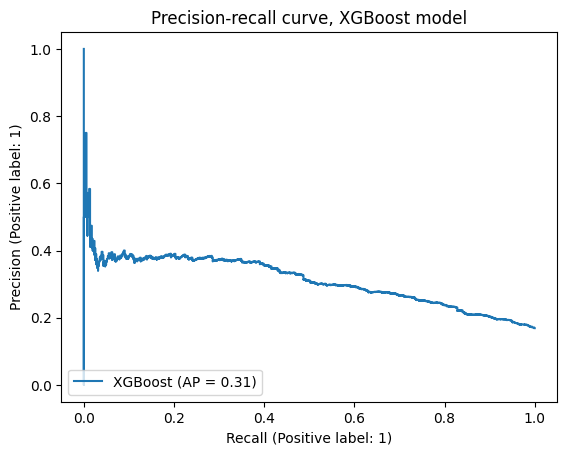

In [62]:
# To plot the precision-recall curve for the XGBoost champion model applied to the test data.
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

In [ ]:
'''
As recall rises, precision tends to decrease. However, as previously discussed when refitting the model for recall, false positives pose minimal concern. So ,in the context 
of our project, a false positive might simply result in a user who ultimately won't churn receiving an email and a banner notification on their phone, representing a very 
low-risk scenario.

In such cases, we could just opt for a lower threshold, instead of adhering to the default 0.5 decision threshold of the model.

Let's see how it would look like when the threshold is adjusted to 0.4:

'''

In [63]:
# Obtain predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.97772163, 0.02227835],
       [0.93271327, 0.06728674],
       [0.9519199 , 0.04808007],
       ...,
       [0.9424333 , 0.05756669],
       [0.6602713 , 0.33972874],
       [0.6461991 , 0.35380086]], dtype=float32)

In [ ]:
'''The predict_proba() method produces a 2-D array of probabilities where each row corresponds to a user. The first number in the row signifies the probability of belonging 
to the negative class, while the second number represents the probability of belonging to the positive class. The two numbers in each row sum to 1. 

By altering the decision threshold for what constitutes a positive response, new predictions based on this array of probabilities can be generated. With the following
code, we will transform the predicted probabilities into {0, 1} predictions using a threshold of 0.4. In essence, this will mean that any users with a value ≥ 0.4 in the 
second column will receive a prediction of 1, indicating churn.'''

In [64]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0])

In [65]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.386986,0.22288,0.282854,0.809


In [66]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.485700,0.120246,0.192621,0.829648
0,XGB cv,0.430060,0.149827,0.221924,0.822870
0,RF val,0.421053,0.094675,0.154589,0.825000
0,XGB val,0.379310,0.130178,0.193833,0.817000
0,XGB test,0.369942,0.126233,0.188235,0.816000


In [ ]:
'''When we compare these numbers with earlier results, we see that there is a significant increase in recall and F1 scores, whereas precision and accuracy decreased slightly.
Thus, guided by the precision-recall curve, let's say we consider a scenario where we determine that a recall score of 0.5 would be satisfactory, and we're willing to accept the 
associated precision score of approximately 30%. Essentially, we would find it acceptable if the model successfully identifies half of the individuals who will genuinely 
churn, even if the correctness of the model's churn predictions is only about 30% of the time.

To achieve the outcome detailed above, we need to determine what threshold should be applied:
'''

In [67]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Input:
        y_test_data: Array containing true y values
        probabilities: Output from the `predict_proba()` model method
        desired_recall: The desired recall score to achieve

    Output:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score corresponding to the determined `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # To create new {0, 1} predictions based on the updated threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # To calculate the recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # To append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # To calculate the proximity of each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # To append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each tuple (from least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to the desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to the desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


In [ ]:
#With the function below, we will find the threshold resulting in a recall score closest to 0.5.

In [68]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.197, 0.5009861932938856)

In [ ]:
# These figures mean that setting a threshold of 0.197 will result in a recall of 0.5.
# To verify:

In [70]:
# Create an array of new predictions that assigns a 1 to any value >= 0.197
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.197 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.197
get_test_scores('XGB, threshold = 0.197', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.197",0.309379,0.500986,0.38253,0.726667


In [ ]:
# Recall score is now 0.50 with the decision threshold set at 0.197.

# The model with the updated decision threshold might now lead the company to target some customers unnecessarily even if they won't actually churn. However, we should also expect that
# more customers who actually churn will be successfully predicted.